# Tutorial 4: Complex-Valued Fields

Written by Adam Morgan

*Last Updated September 24, 2024*

In this tutorial, I'll give an example of how *joe* can handle PDEs whose solutions are *complex-valued*. To keep the discussion concrete, we study the **cubic nonlinear Schroedinger equation (NLS)**: for a parameter $g=\pm 1$, this equation reads

$$
u_{t} - iu_{xx} = ig\left|u\right|^2u, \quad u\colon \mathbb{R}\times\mathbb{R}\rightarrow \mathbb{R}.  
$$

When $g=+1$, we say we are dealing with the **focusing NLS**, and if $g=-1$ then we are dealing with the **defocusing NLS**. 

NLS is a "universal" model for the evolution of weakly nonlinear disperive wavepackets, and is particularly important in fibre optics and the theory of water waves. For more on the mathematics and physics of NLS, please see the references. 

NLS admits many interesting exact solutions, including solitons. Given $a>0, c\in \mathbb{R}$, these solitons take the form 

$$
U(x,t;a,c) = \sqrt{2a} \ \text{sech}\left(\sqrt{a}\left(x-ct\right)\right) \ \exp\left[i\left(\frac{c}{2}x+\left(a-\frac{c^2}{4}\right)t\right)\right]. 
$$

Note how the "envelope" (the sech-term) travels at speed $c$ while the oscillatory term travels at a different speed depending on both $a$ and $c$. 

Additionally, NLS admits infinitely many conservation laws, including

$$
\text{mass} = M[u] = \int_{-\infty}^{+\infty} \left|u(x,t)\right|^2 \ \mathrm{d} x = \text{constant}, 
$$

$$
\text{momentum} = P[u] = \int_{-\infty}^{+\infty} \text{Im}\left(\overline{u}u_{x}\right) \ \mathrm{d} x = \text{constant}, \quad \text{and}
$$

$$
\text{energy} = E[u] = \int_{-\infty}^{+\infty} \left|u_x\right|^2-\frac{g}{4}\left|u\right|^4 \ \mathrm{d} x = \text{constant}.
$$

Below, we use *joe* to solve the focusing NLS with initial state 

$$
u|_{t=0} = U(x,0; 1,1)
$$

to verify that we can reproduce the soliton solution. We also use the helper function $\texttt{integrate}$ discussed in tutorial 3 to verify that our solution respects the conservation laws highlighted above. Along the way, we'll see how *joe* handles complex-valued solutions slightly differently than real-valued ones, both in terms of object definitions and visualizations. 

### Recommendations for Further Reading 

- Newell, *Solitons in Mathematics and Physics*, SIAM, 1985. https://epubs.siam.org/doi/book/10.1137/1.9781611970227

- Sulem and Sulem, *The Nonlinear Schrödinger Equation: Self-Focusing and Wave Collapse*, Springer, 1999. https://link.springer.com/book/10.1007/b98958

## Solving the Focusing NLS with *joe*

In [1]:
import numpy as np

from scipy.fft import fft, ifft

import joe_lab.joe as joe

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%matplotlib inline
%config InlineBackend.figure_format='retina'

import os

# add the folder "joe_visuals" to our path
my_path = os.path.join("joe_visuals")

# first, if the folder doesn't exist, make it
if not os.path.isdir(my_path):
    os.makedirs(my_path)

# make sure Image and Video can be displayed in the notebook. 
from IPython.display import Image, Video

Let's start by defining our $\texttt{model}$. If the soln is complex, this must be told to the program explicitly by passing $\texttt{complex=True}$ into the instantiaion of our $\texttt{model}$.

In [2]:
g = 1. # focusing case 

def my_symbol(k):
    return -1j*k**2

def my_fourier_forcing(V,k,x,nonlinear=True):

    u = ifft(V) # note that we use fft, ifft instead of rfft, irfft!!!!

    out =  fft(float(nonlinear)*1j*g*u*np.absolute(u)**2)

    return out

model_kw = 'focusing_nls'

my_model = joe.model(model_kw, 1, my_symbol, my_fourier_forcing, nonlinear=True, complex=True)

There is no substantial change between real and complex fields when it comes to the initial state, except for one tiny numpy detail. 

In [3]:
def nls_soliton(x,a=1., c=1.):

    out = 1j*np.zeros_like(x) # this is the only difference between real and complex initial states!
    # If an array will EVER have complex entries, python likes to know as soon as that array is created. 

    xmax = 180
    out[abs(x) > xmax] = 0.
    out[abs(x) <= xmax] = np.sqrt(2.*a)*np.exp(1j*0.5*c*x[abs(x) <= xmax])/np.cosh(np.sqrt(a)*x[abs(x) <= xmax])

    return out

my_initial_state = joe.initial_state('nls_soliton', nls_soliton)

Defining a space-time grid is, of course, unchanged.

In [4]:
length, T, N, dt = 100., 100., 2**9, 2e-3
stgrid = {'length':length, 'T':T, 'N':N, 'dt':dt}

Likewise, defining and running the simulation is the same as in the real case: we should only be telling the computer that the field is complex **once!**

In [5]:
my_sim = joe.simulation(stgrid, my_model, my_initial_state, bc='periodic', ndump=60)
my_sim.load_or_run(method_kw='etdrk4', save=True)

No saved simulation found, running simulation.
Simulation runtime = 2.645 s


Hovmoeller plots work a little differently for complex-valued fields. If you call $\texttt{hov\_plot}$ on $\texttt{my\_sim}$, it automatically creates plots of the real AND imaginary parts of the field. You should take note of the naming conventions for both of these plots below. 

In [6]:
my_sim.hov_plot(show_figure=False, save_figure=True, usetex=True, cmap='plasma')

Rendering Hovmoeller plot... |████████████████████████████████████████| in 1.4s 


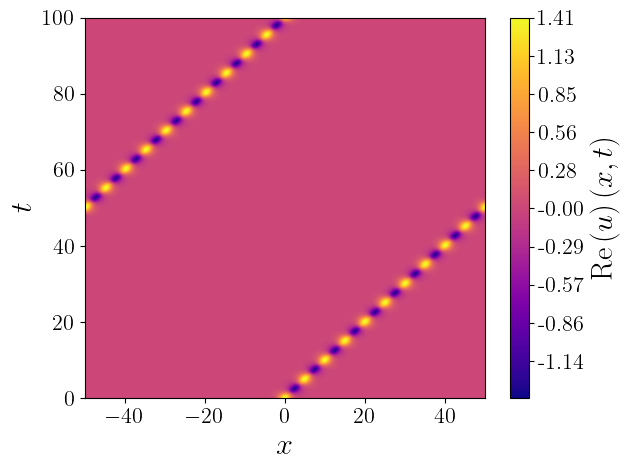

In [7]:
Image('joe_visuals/' + my_sim.realpicname, embed=True)

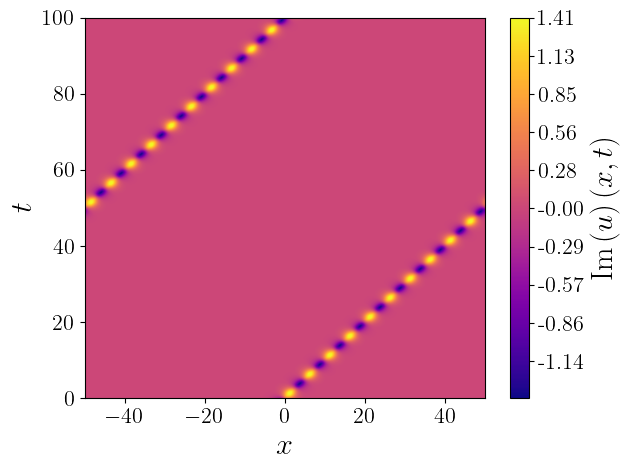

In [8]:
Image('joe_visuals/' + my_sim.imagpicname, embed=True)

From these plots, we find *joe* is nicely reproducing the NLS soliton. 

This can also be done easily with *one* plot by calling a Hovmoeller plot of the modulus $\left|u\right|$ instead: 

Rendering Hovmoeller plot of modulus... |███████████████████████████████████████


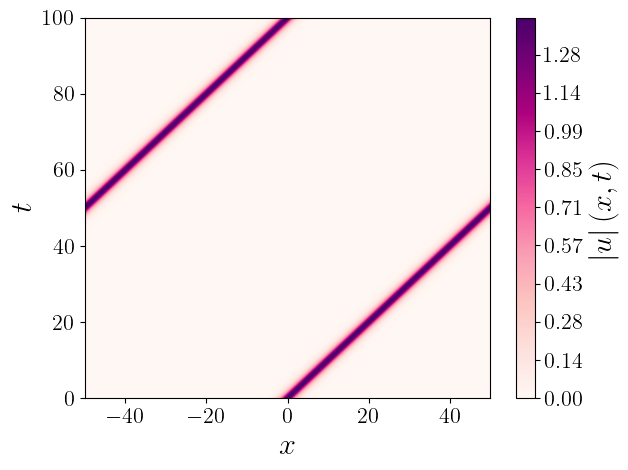

In [9]:
my_sim.hov_plot_modulus(show_figure=False, save_figure=True, usetex=True, cmap='RdPu')
Image('joe_visuals/' + my_sim.modpicname, embed=True)

The uniform motion of the soliton envelope emerges nicely from this image. 

Movies work analogously: the usual $\texttt{save\_movie}$ function will save both the real and imaginary parts, or you can call the specialized function $\texttt{save\_movie\_modulus}$ if you only want a movie of $\left|u\right|$.  

In [10]:
my_sim.save_movie(fps=100, usetex=False, fieldcolor='xkcd:heliotrope')

Rendering movie... |████████████████████████████████████████| in 37.6s          


In [11]:
Video('joe_visuals/' + my_sim.realmoviename, embed=True)

In [12]:
Video('joe_visuals/' + my_sim.imagmoviename, embed=True)

In [13]:
my_sim.save_movie_modulus(fps=100, usetex=False, fieldcolor='xkcd:barney purple')

Rendering movie of modulus... |████████████████████████████████████████| in 21.2


In [14]:
Video('joe_visuals/' + my_sim.modmoviename, embed=True)

$\texttt{save\_combomovie}$ can be called on complex-valued fields too, but it only shows $\left|u\right|$ and the power spectrum rather than real and/or imaginary parts. To avoid cluttering the demo, I won't reproduce the code here. 

## Checking the Conservation Laws

Next, we check how well our simulation satisfies the relevant conservation laws introduced earlier. 

In [15]:
from scipy.fft import fftfreq
from joe_lab.visualization import nice_plot
from joe_lab.utils import integrate

dpi = 400

In [16]:
Udata = my_sim.Udata

def mass(u):

    out = integrate(np.absolute(u)**2, length)

    return out

def momentum(u):

    # get wavenumbers for the grid of S^1 with N samples
    k = 2. * np.pi * N * fftfreq(N) / length

    ux = ifft(1j*k*fft(u))

    out = integrate(np.imag(np.conjugate(u)*ux), length)

    return out 

def energy(u):

    # get wavenumbers for the grid of S^1 with N samples
    k = 2. * np.pi * N * fftfreq(N) / length

    ux = ifft(1j*k*fft(u))

    uxsq = np.absolute(ux)**2

    potential = - .25*g*np.absolute(u)**4

    out = integrate(uxsq+potential, length)

    return out 

In [17]:
times = np.linspace(0., T, num=1 + int(T / (dt*my_sim.ndump)), endpoint=True)
M = mass(Udata)
P = momentum(Udata)
E = energy(Udata)

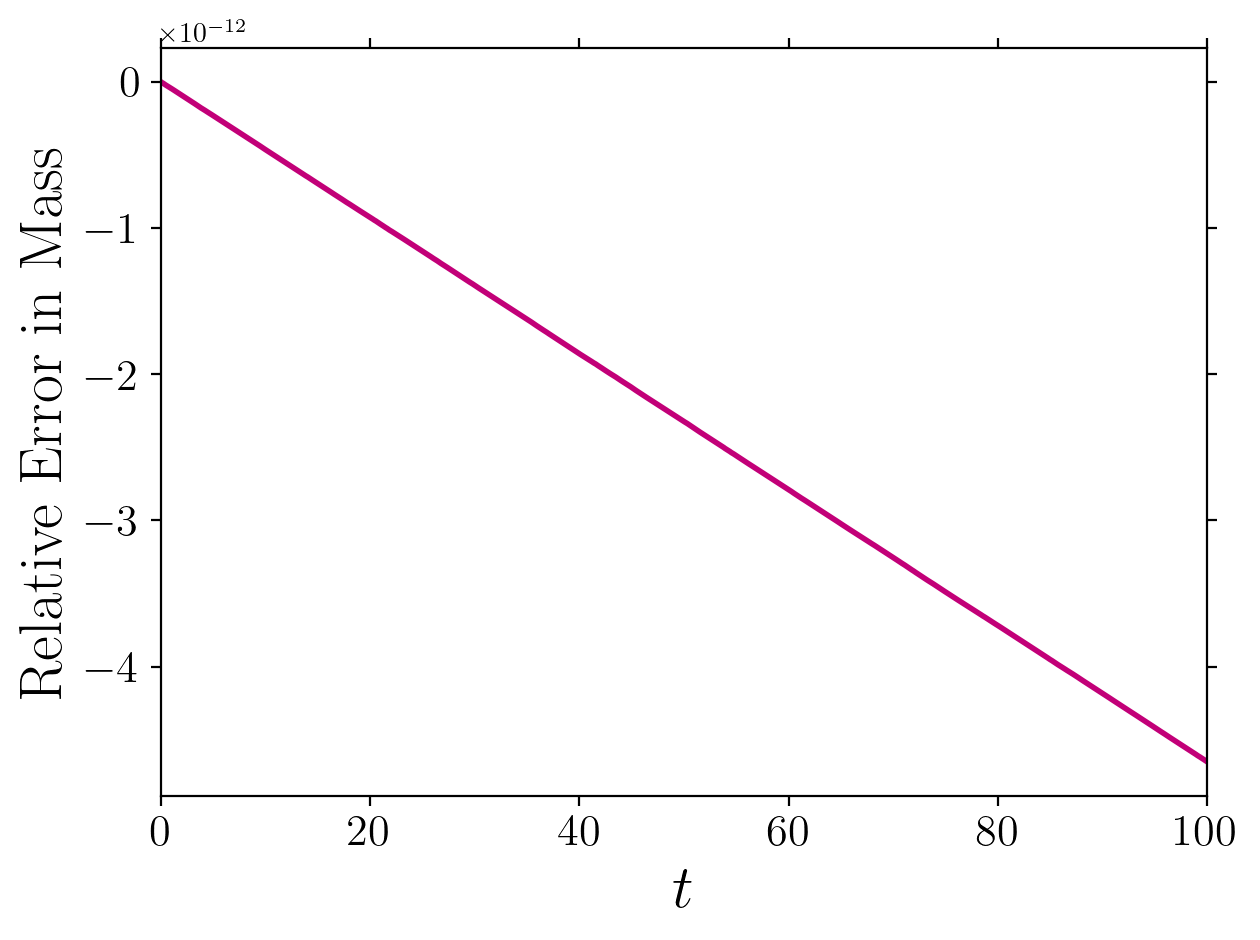

In [18]:
picname = 'nls_mass_test_length=%.1f_T=%.1f_N=%.1f_dt=%.6f' % (length, T, N, dt) + '_ICkw=' + my_sim.initial_state_kw  + '.png'
nice_plot(times, (M-M[0])/M[0], r'$t$', r'Relative Error in Mass', dpi=dpi, show_figure=True,
          save_figure=True, picname=picname, linestyle='solid', color='xkcd:magenta', usetex=True)

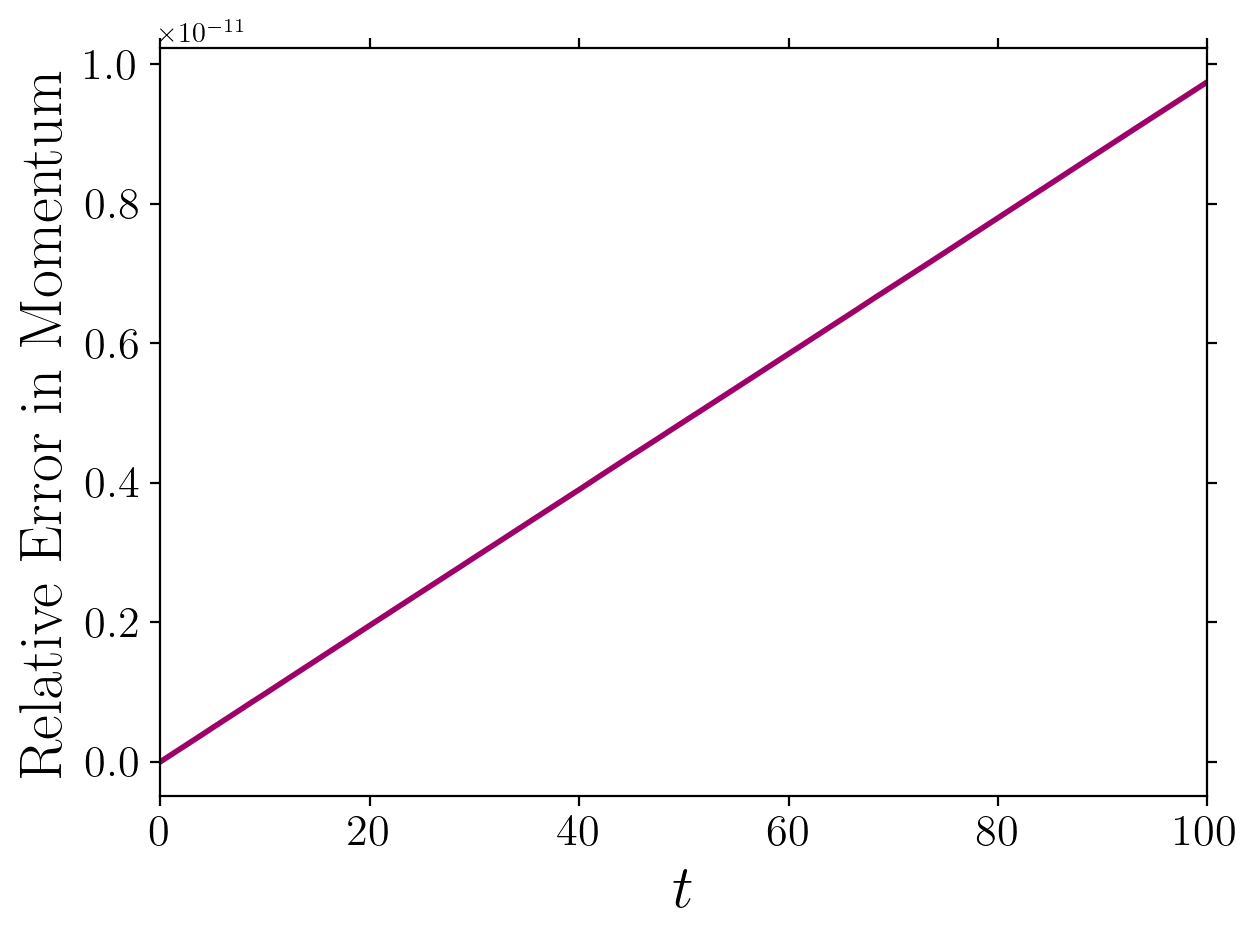

In [19]:
picname = 'nls_momentum_test_length=%.1f_T=%.1f_N=%.1f_dt=%.6f' % (length, T, N, dt) + '_ICkw=' + my_sim.initial_state_kw  + '.png'
nice_plot(times, (P-P[0])/P[0], r'$t$', r'Relative Error in Momentum', dpi=dpi, show_figure=True,
          save_figure=True, picname=picname, linestyle='solid', color='xkcd:red violet', usetex=True)

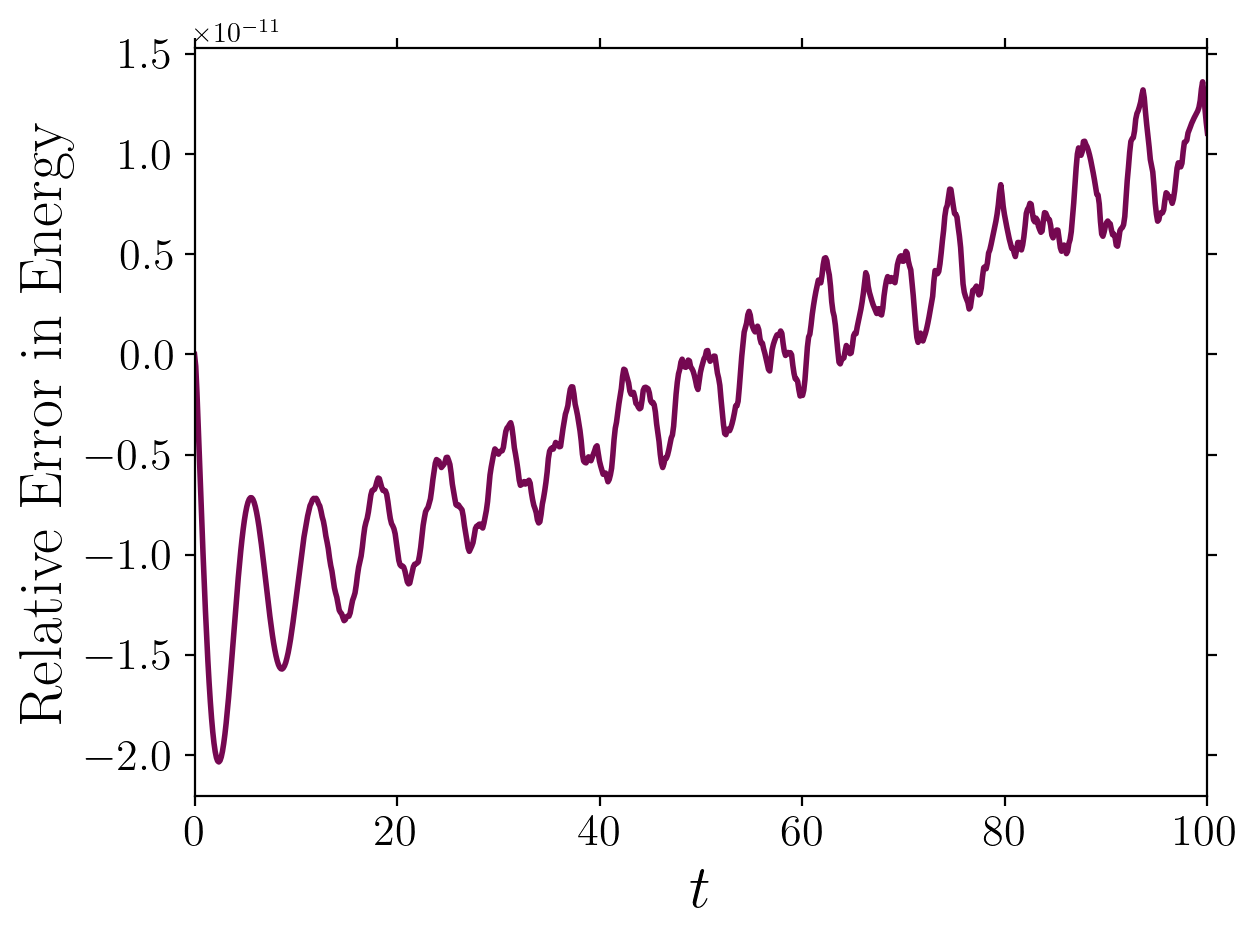

In [20]:
picname = 'nls_energy_test_length=%.1f_T=%.1f_N=%.1f_dt=%.6f' % (length, T, N, dt) + '_ICkw=' + my_sim.initial_state_kw  + '.png'
nice_plot(times, (E-E[0])/E[0], r'$t$', r'Relative Error in Energy', dpi=dpi, show_figure=True,
          save_figure=True, picname=picname, linestyle='solid', color='xkcd:velvet', usetex=True)

So, all three quantities are numerically conserved to high precision. However, the trends in mass and momentum errors are monotone, and the energy error is monotone "on average". These observations suggest that care should be used in simulations on extremely long time scales.